In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
import yaml
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics.classification import BinaryFBetaScore

from src.model.modules import SegmentationModule
from src.data.datamodules import SurfaceVolumeDatamodule

The ``converters`` are currently experimental. It may not support operations including (but not limited to) Functions in ``torch.nn.functional`` that involved data dimension


In [3]:
config_path = '/workspace/scrolls/run/configs/2d/unet-2d.yaml'
ckpt_path = '/workspace/scrolls/scrolls/s81vkmu5/checkpoints/last.ckpt'

In [4]:
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

config['trainer']['accumulate_grad_batches'] = 2
config['model']['init_args']['backbone_name'] = 'convnextv2_large.fcmae_ft_in22k_in1k_384'
config['data']['init_args']['crop_size'] = 768
config['data']['init_args']['crop_size_z'] = 6
config['data']['init_args']['img_size'] = 768
config['data']['init_args']['img_size_z'] = 6
config['data']['init_args']['batch_size'] = 4

In [5]:
model = SegmentationModule(**config['model']['init_args'])
state_dict = torch.load(ckpt_path)['state_dict']
model.load_state_dict(state_dict)
model = model.eval().cuda()

In [6]:
id(model.model), id(model.tta.model)

(139837702091920, 139837702091920)

In [7]:
datamodule = SurfaceVolumeDatamodule(**config['data']['init_args'])
datamodule.setup()
dataloader = datamodule.val_dataloader()

Unknown scale for /workspace/data/fragments_z_shift_scale/train/1, assuming 1.0
Unknown scale for /workspace/data/fragments_z_shift_scale/train/2, assuming 1.0
Unknown scale for /workspace/data/fragments_z_shift_scale/train/3, assuming 1.0
12it [00:05,  2.13it/s]
12it [00:18,  1.53s/it]
12it [00:04,  2.45it/s]


In [8]:
# 3 x 4 grid
#   rows are flips (no, horizontal, vertical)
#   columns are rotations (0, 90, 180, 270)
row_col_to_tta = {
    (0, 0): 'no TTA',
    (0, 1): 'horizontal flip, 90 deg',
    (0, 2): 'horizontal flip, 180 deg',
    (0, 3): 'horizontal flip, 270 deg',
    (1, 0): 'vertical flip, 0 deg',
    (1, 1): 'vertical flip, 90 deg',
    (1, 2): 'vertical flip, 180 deg',
    (1, 3): 'vertical flip, 270 deg',
    (2, 0): 'horizontal and vertical flip, 0 deg',
    (2, 1): 'horizontal and vertical flip, 90 deg',
    (2, 2): 'horizontal and vertical flip, 180 deg',
    (2, 3): 'horizontal and vertical flip, 270 deg',
}
pred_index_to_tta = {i * 4 + j: tta for (i, j), tta in row_col_to_tta.items()}

### Toy example

In [9]:
# Create example image with L letter in the middle
img = torch.zeros((1, 1, 10, 10))
img[0, 0, 3:8, 3:4] = 1
# img[0, 0, 3:8, 7:9] = 1
# img[0, 0, 3:5, 3:9] = 1
img[0, 0, 7:8, 3:7] = 1

# Enlarge image to 768x768 and tile it 6 times along new last dimension
img = img.unsqueeze(-1).repeat(1, 1, 1, 1, 6)
img = F.interpolate(img, size=(768, 768, 6), mode='nearest')

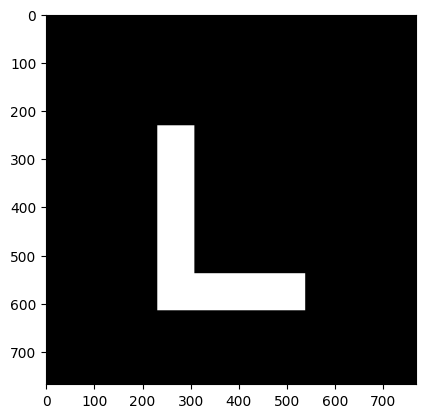

In [10]:
plt.imshow(img[0, 0, :, :, img.shape[4] // 2].cpu().numpy(), cmap='gray')

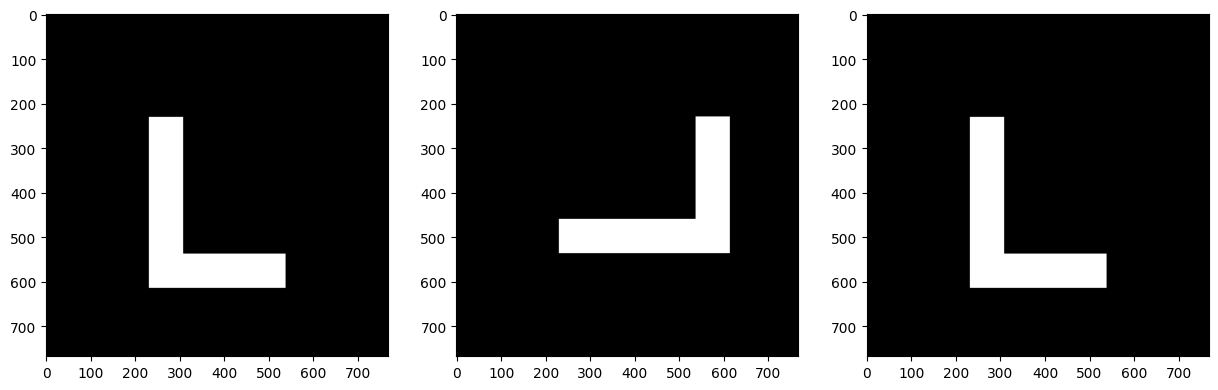

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes = axes.flatten()

# Original image
axes[0].imshow(
    img[0, 0, :, :, img.shape[4] // 2].cpu()
        .numpy(), cmap='gray'
)

# Rotated 90 deg
axes[1].imshow(
    img[0, 0, :, :, img.shape[4] // 2].cpu()
        .clone().rot90(1, [0, 1]).numpy(), cmap='gray')

# Rotated 90 deg and rotated back
axes[2].imshow(
    img[0, 0, :, :, img.shape[4] // 2].cpu()
        .clone().rot90(1, [0, 1])
        .rot90(-1, [0, 1]).numpy(), cmap='gray'
)

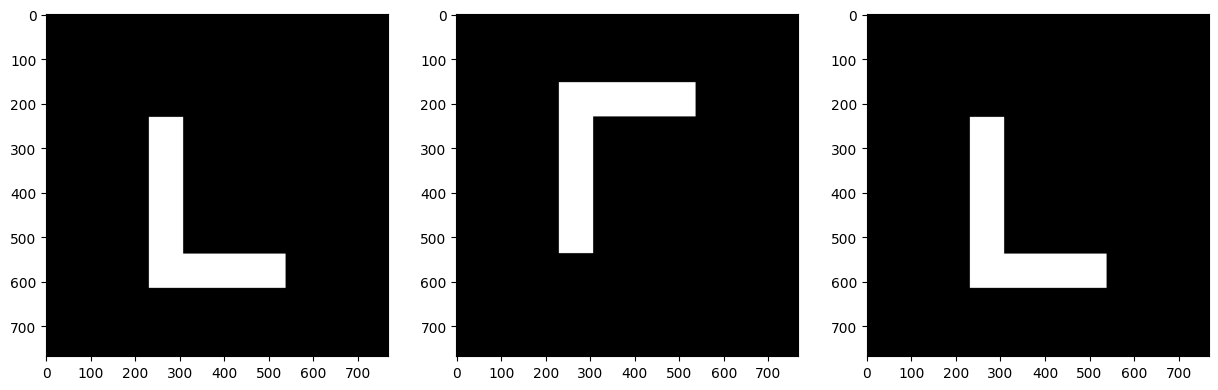

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes = axes.flatten()

# Original image
axes[0].imshow(
    img[0, 0, :, :, img.shape[4] // 2].cpu()
        .numpy(), cmap='gray'
)

# Vertical flip
axes[1].imshow(
    img.clone().flip(2)[0, 0, :, :, img.shape[4] // 2].cpu()
        .numpy(), cmap='gray')

# Rotated 90 deg and rotated back
axes[2].imshow(
    img.clone().flip(2).flip(2)[0, 0, :, :, img.shape[4] // 2].cpu()
        .numpy(), cmap='gray'
)

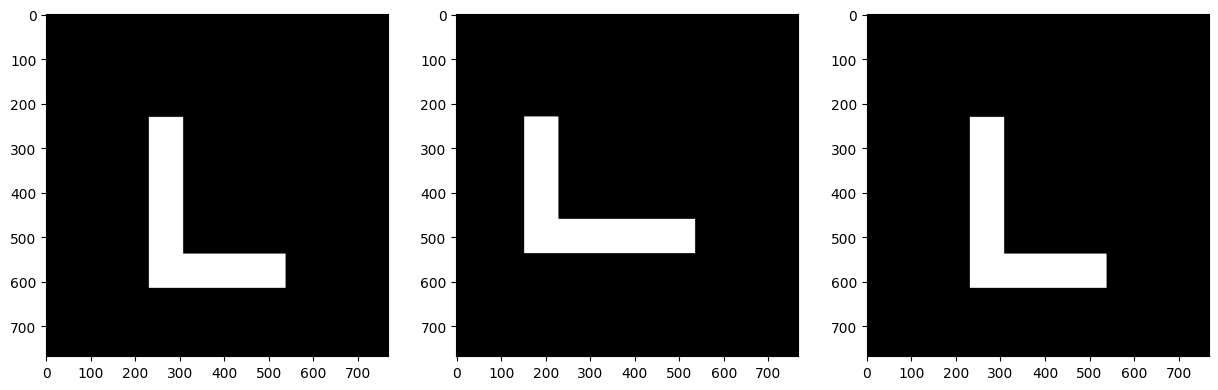

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes = axes.flatten()

# Original image
axes[0].imshow(
    img[0, 0, :, :, img.shape[4] // 2].cpu()
        .numpy(), cmap='gray'
)

# Rotated 90 deg & vertical flip
axes[1].imshow(
    img.clone().flip(2).rot90(1, (2, 3))[0, 0, :, :, img.shape[4] // 2].cpu().numpy(), cmap='gray')

# Rotated 90 deg & vertical flip then undo
axes[2].imshow(
    img.clone().flip(2).rot90(1, (2, 3)).rot90(-1, (2, 3)).flip(2)[0, 0, :, :, img.shape[4] // 2].cpu().numpy(), cmap='gray')

In [14]:
tta = model.tta
tta.model = lambda x: x[..., 0]

In [15]:
preds = tta.predict(img)

In [16]:
mask = img[:, 0, ..., 0]

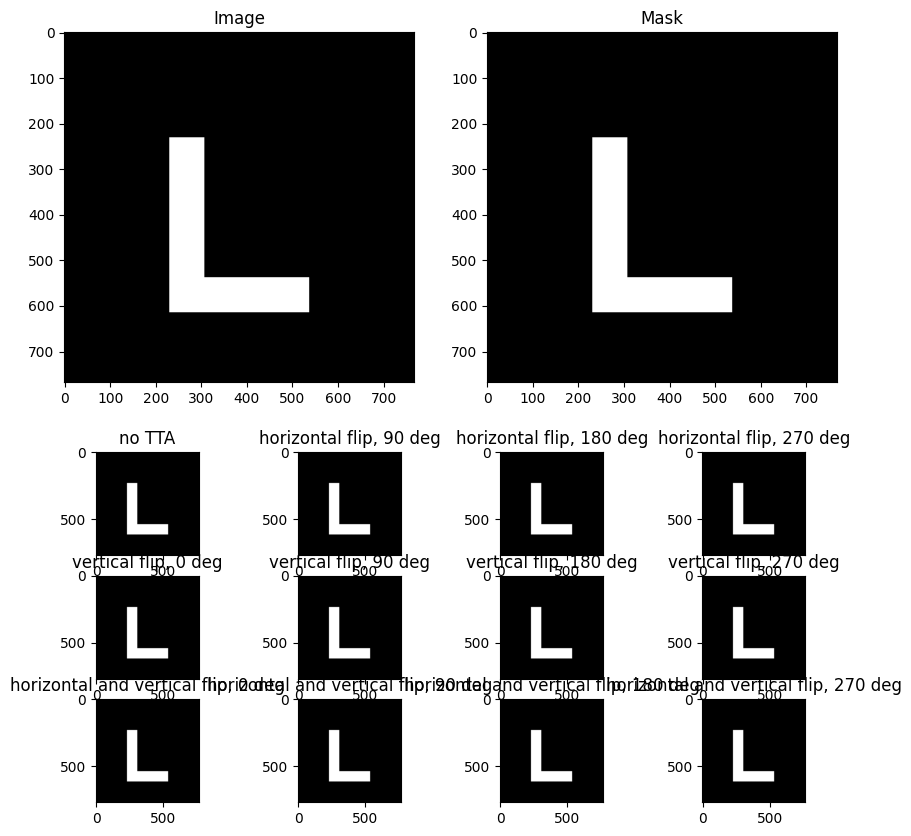

In [17]:
# Create grid via gridspec with 2 subgrid rows: 
# subgrid 1: 1x2 for img and mask, 
# subgrid 2: 3x4 for TTAs
#   rows are flips (no, horizontal, vertical)
#   columns are rotations (0, 90, 180, 270)
# subgrids 1 and 2 equally high
# for item_index in range(config['data']['init_args']['batch_size']):
for item_index in range(1):
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 1])
    gs1 = gs[0].subgridspec(1, 2)
    gs2 = gs[1].subgridspec(3, 4)

    # Subgrid 1: img and mask
    ax1 = fig.add_subplot(gs1[0, 0])
    ax1.imshow(img[item_index, 0, :, :, img.shape[4] // 2].cpu().numpy(), cmap='gray')
    ax1.set_title('Image')
    ax2 = fig.add_subplot(gs1[0, 1])
    ax2.imshow(mask[item_index, :, :].cpu().numpy(), cmap='gray')
    ax2.set_title('Mask')

    # Subgrid 2: TTAs
    for i in range(3):
        for j in range(4):
            ax = fig.add_subplot(gs2[i, j])
            pred_index = i * 4 + j
            pred = preds[pred_index]
            ax.imshow(pred[item_index, 0, :, :].cpu().numpy(), cmap='gray')
            ax.set_title(row_col_to_tta[(i, j)])

In [18]:
tta.model = model.model

### Real example

In [19]:
with torch.no_grad():
    metrics = [BinaryFBetaScore(0.5).cuda() for _ in range(12 + 1)]
    for batch in tqdm(dataloader):
        img = batch['image'].cuda()
        preds = model.tta.predict(img)
        
        avg_pred = []
        for i in range(12):
            mask, preds_current = model.extract_targets_and_probas_for_metric(preds[i], batch)
            mask_flattened = mask.cuda().flatten()[batch['mask_0'].flatten() == 1]
            preds_current_flattened = preds_current.flatten()[batch['mask_0'].flatten() == 1]
            metrics[i].update(preds_current_flattened, mask_flattened)
            avg_pred.append(preds_current_flattened)
        
        avg_pred = torch.stack(avg_pred, dim=0).nanmean(dim=0)
        metrics[-1].update(avg_pred, mask_flattened)

100%|██████████| 53/53 [03:02<00:00,  3.45s/it]


In [20]:
for i in range(12):
    print(f'{pred_index_to_tta[i]}: {metrics[i].compute().item()}')
print(f'Average: {metrics[-1].compute().item()}')

no TTA: 0.6437771320343018
horizontal flip, 90 deg: 0.6447690725326538
horizontal flip, 180 deg: 0.6408140063285828
horizontal flip, 270 deg: 0.6369031667709351
vertical flip, 0 deg: 0.656807541847229
vertical flip, 90 deg: 0.6393662691116333
vertical flip, 180 deg: 0.6534693241119385
vertical flip, 270 deg: 0.6381237506866455
horizontal and vertical flip, 0 deg: 0.6534693241119385
horizontal and vertical flip, 90 deg: 0.6381237506866455
horizontal and vertical flip, 180 deg: 0.656807541847229
horizontal and vertical flip, 270 deg: 0.6393662691116333
Average: 0.6640353202819824


In [21]:
img.shape, mask.shape, preds[0].shape, len(preds)

(torch.Size([3, 1, 768, 768, 6]),
 torch.Size([3, 768, 768]),
 torch.Size([3, 1, 768, 768]),
 12)

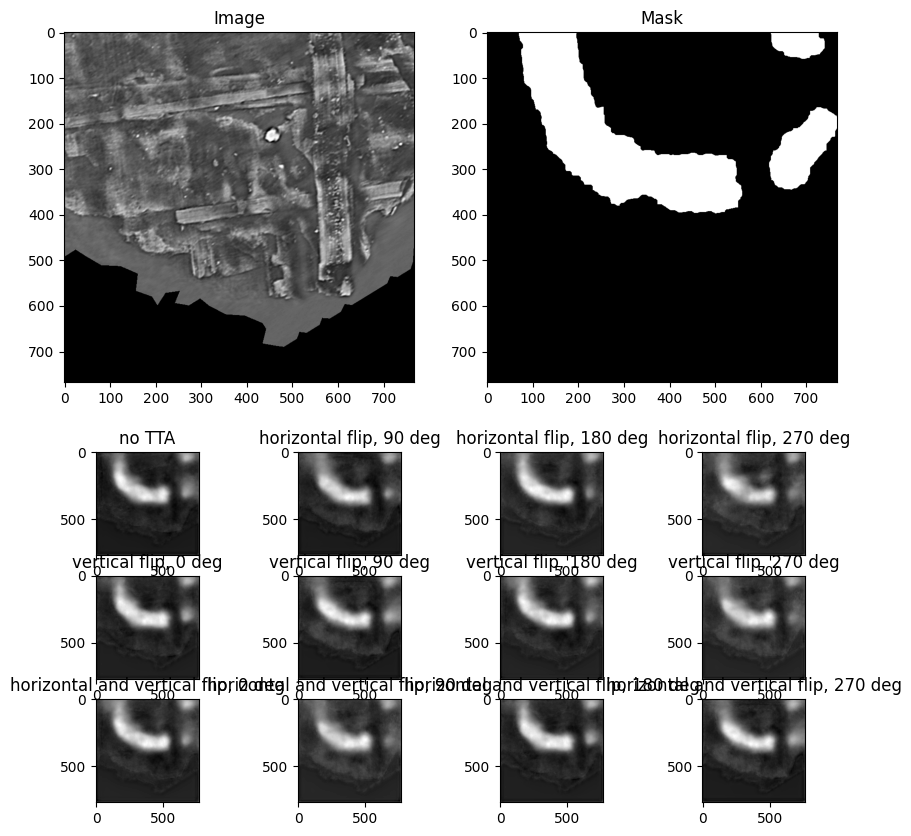

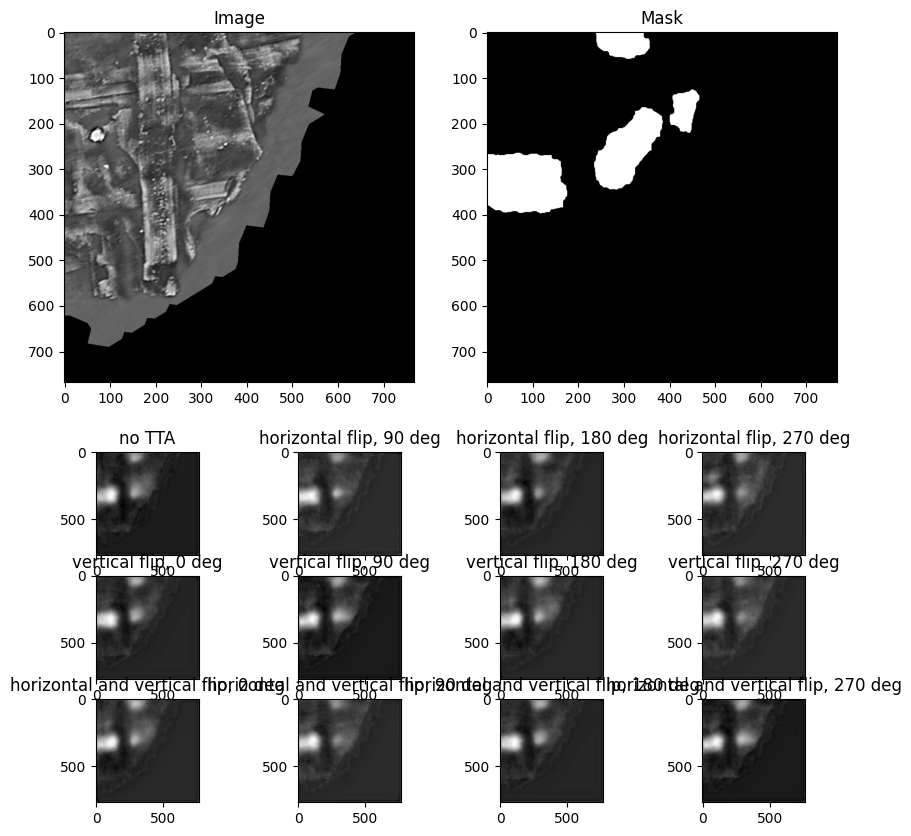

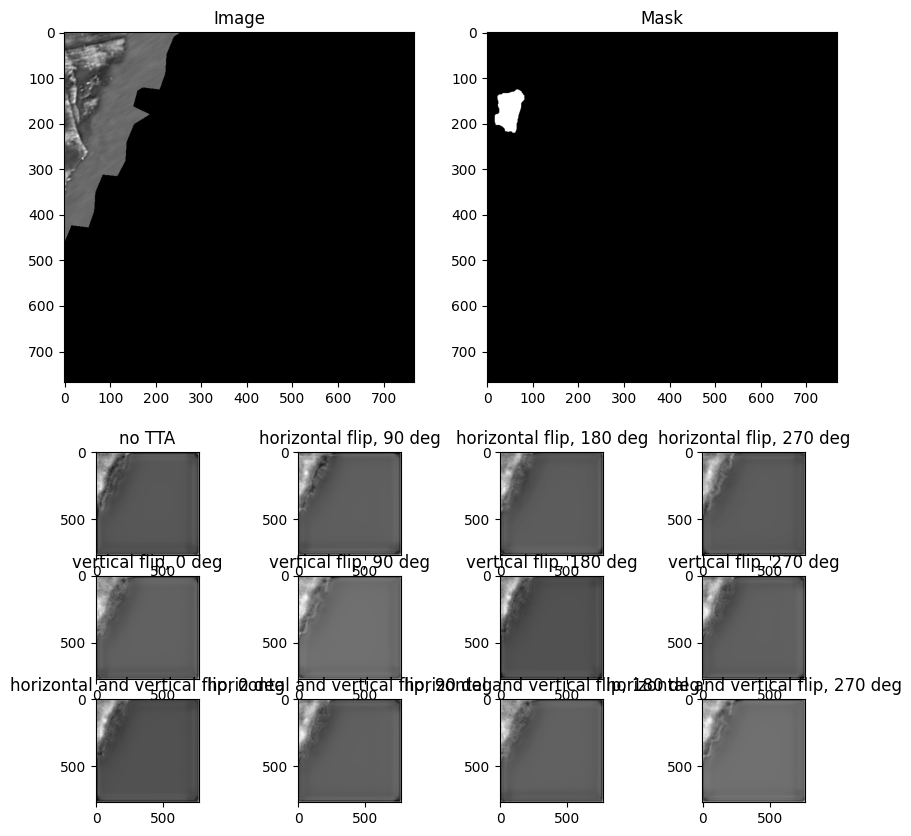

In [22]:
# Create grid via gridspec with 2 subgrid rows: 
# subgrid 1: 1x2 for img and mask, 
# subgrid 2: 3x4 for TTAs
#   rows are flips (no, horizontal, vertical)
#   columns are rotations (0, 90, 180, 270)
# subgrids 1 and 2 equally high
# for item_index in range(config['data']['init_args']['batch_size']):
for item_index in range(3):
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 1])
    gs1 = gs[0].subgridspec(1, 2)
    gs2 = gs[1].subgridspec(3, 4)

    # Subgrid 1: img and mask
    ax1 = fig.add_subplot(gs1[0, 0])
    ax1.imshow(img[item_index, 0, :, :, img.shape[4] // 2].cpu().numpy(), cmap='gray')
    ax1.set_title('Image')
    ax2 = fig.add_subplot(gs1[0, 1])
    ax2.imshow(mask[item_index, :, :].cpu().numpy(), cmap='gray')
    ax2.set_title('Mask')

    # Subgrid 2: TTAs
    for i in range(3):
        for j in range(4):
            ax = fig.add_subplot(gs2[i, j])
            pred_index = i * 4 + j
            pred = preds[pred_index]
            ax.imshow(pred[item_index, 0, :, :].cpu().numpy(), cmap='gray')
            ax.set_title(row_col_to_tta[(i, j)])